In [3]:

!pip install transformers torch sklearn pandas

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [5]:
!pip install nlpaug

In [2]:
!pip install ipython-autotime

%load_ext autotime

time: 317 µs (started: 2023-12-06 15:53:08 +00:00)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 810 ms (started: 2023-12-06 15:53:08 +00:00)


In [4]:
!pip install tensorflow==2.14.0

time: 5.63 s (started: 2023-12-06 15:53:14 +00:00)


In [5]:
# Import libraries
import transformers
import os
import nlpaug.augmenter.word as naw
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import pickle
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from torch.nn import functional
from transformers import AdamW

time: 6.77 s (started: 2023-12-06 15:53:22 +00:00)


In [6]:
# Load and preprocess dataset
try:
    dataset = pd.read_csv('/content/train_title_abstract_keywords.csv', encoding='utf-8')
except UnicodeDecodeError:
    dataset = pd.read_csv('/content/train_title_abstract_keywords.csv', encoding='latin1')
# Combining title, subtitle, and abstract
X = dataset[['Title', 'Subtitle', 'Abstract']].fillna('').agg(' '.join, axis=1)
y = dataset['Keywords']

time: 6.74 s (started: 2023-12-06 15:53:35 +00:00)


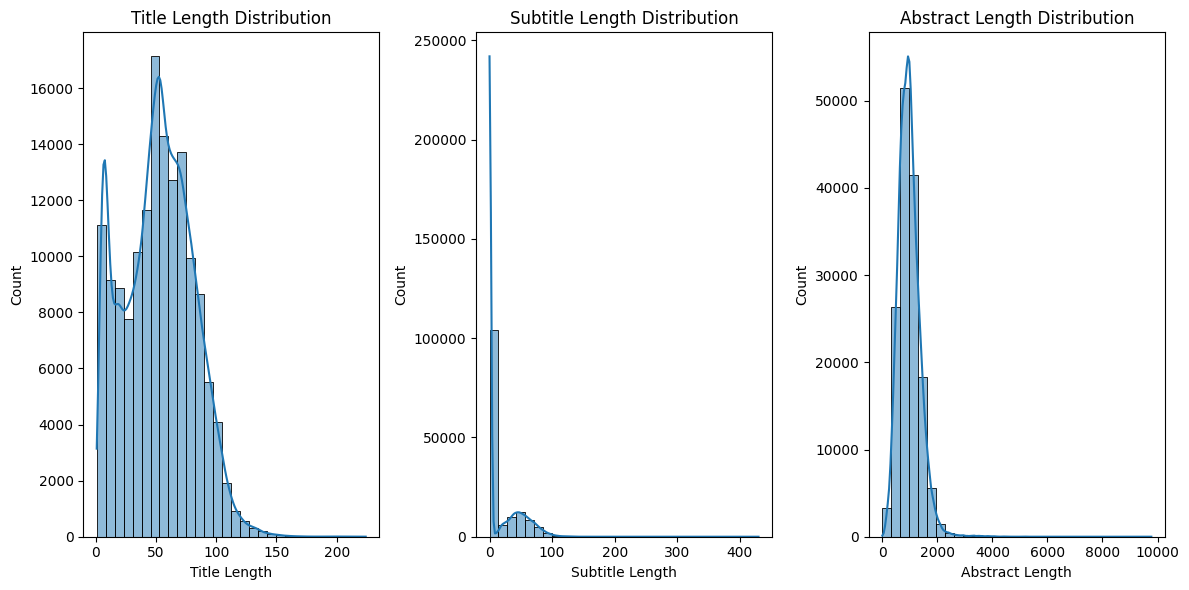

In [ ]:
#VISUALIZE DATA
import matplotlib.pyplot as plt
import seaborn as sns

dataset['Title'] = dataset['Title'].fillna('')
dataset['Subtitle'] = dataset['Subtitle'].fillna('')
dataset['Abstract'] = dataset['Abstract'].fillna('')

# Calculating lengths
dataset['Title Length'] = dataset['Title'].apply(len)
dataset['Subtitle Length'] = dataset['Subtitle'].apply(len)
dataset['Abstract Length'] = dataset['Abstract'].apply(len)

# Plotting
plt.figure(figsize=(12, 6))

# Title Length Distribution
plt.subplot(1, 3, 1)
sns.histplot(dataset['Title Length'], bins=30, kde=True)
plt.title('Title Length Distribution')

# Subtitle Length Distribution
plt.subplot(1, 3, 2)
sns.histplot(dataset['Subtitle Length'], bins=30, kde=True)
plt.title('Subtitle Length Distribution')

# Abstract Length Distribution
plt.subplot(1, 3, 3)
sns.histplot(dataset['Abstract Length'], bins=30, kde=True)
plt.title('Abstract Length Distribution')

plt.tight_layout()
plt.show()

In [7]:
#BERT MODEL_1
tokenizer_bert_base = BertTokenizer.from_pretrained('bert-base-uncased')

time: 243 ms (started: 2023-12-06 15:53:44 +00:00)


In [8]:
#TOKENIZER RESULTS - BERT BASE
import random
vocab_list = list(tokenizer_bert_base.vocab.keys())
random.sample(vocab_list, 20)

['achieved',
 'reinforcements',
 'visits',
 '##tri',
 'scully',
 'ramsay',
 'verification',
 'guarded',
 'ascent',
 'sigma',
 '[unused735]',
 'deluxe',
 'צ',
 'combat',
 'linking',
 'plenty',
 '—',
 'minerals',
 'boyd',
 'graduate']

time: 5.89 ms (started: 2023-12-06 15:53:49 +00:00)


In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
labels = torch.tensor(y_encoded)

time: 474 ms (started: 2023-12-06 15:53:52 +00:00)


In [10]:
# Data Preparation for BERT

tokenized_data_path = "/content/tokenized_data.pkl"

if os.path.exists(tokenized_data_path):
    with open(tokenized_data_path, 'rb') as file:
        tokenized_data = pickle.load(file)
    input_ids, attention_masks = tokenized_data
else:
    input_ids = []
    attention_masks = []

    for text in X:
        encoded_dict = tokenizer_bert_base.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=64,
                            truncation=True,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                       )
        input_ids.append(encoded_dict['input_ids'][0])
        attention_masks.append(encoded_dict['attention_mask'][0])

    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)

    # Save the tokenized data
    tokenized_data = (input_ids, attention_masks)
    with open(tokenized_data_path, 'wb') as file:
        pickle.dump(tokenized_data, file)


time: 2.97 s (started: 2023-12-06 15:53:54 +00:00)


In [11]:
print(f"Length of input_ids: {input_ids.size(0)}")
print(f"Length of attention_masks: {attention_masks.size(0)}")
print(f"Length of labels: {labels.size(0)}")

unique_labels = torch.unique(labels)
print("Min label:", torch.min(labels).item())
print("Max label:", torch.max(labels).item())


Length of input_ids: 148928
Length of attention_masks: 148928
Length of labels: 148928
Min label: 0
Max label: 145899
time: 30.4 ms (started: 2023-12-06 15:53:57 +00:00)


In [ ]:
#TRAIN BERT_BASE MODEL - 1
bert_base = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(unique_labels))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_base.to(device)

# Optimizer
optimizer = AdamW(bert_base.parameters(), lr=2e-5, eps=1e-8)

# Loss function
criterion = torch.nn.CrossEntropyLoss()
dataset = TensorDataset(input_ids, attention_masks, labels)

# Splitting data into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=128)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=128)

# Training Loop
epochs = 3
for epoch in range(epochs):
    # Training phase
    bert_base.train()
    total_train_loss = 0
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)
        bert_base.zero_grad()

        # Forward pass
        outputs = bert_base(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_train_loss += loss.item()

        # Backward pass
        loss.backward()

        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation phase
    bert_base.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            outputs = bert_base(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]
        total_eval_loss += loss.item()

    #Average validation loss over the epoch
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Training loss: {avg_train_loss}')
    print(f'Validation loss: {avg_val_loss}')



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Training loss: 11.901959293254848
Validation loss: 12.13157661585337
Epoch 2/3
Training loss: 11.86732724555453
Validation loss: 12.359702515499785
Epoch 3/3
Training loss: 11.780753452206785
Validation loss: 13.291357887660997


In [ ]:
# Saving the Model
model_directory = "/content/bert_base_uncased"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

bert_base.save_pretrained(model_directory)

In [ ]:
'''import nlpaug.augmenter.word as naw

train_dataset_path = '/content/train_title_abstract_keywords.csv'
try:
    train_dataset = pd.read_csv('/content/train_title_abstract_keywords.csv', encoding='utf-8')
except UnicodeDecodeError:
    train_dataset = pd.read_csv('/content/train_title_abstract_keywords.csv', encoding='latin1')

X = dataset[['Title', 'Abstract']].fillna('').agg(' '.join, axis=1)
y = dataset['Keywords']

# text augmentation
def augment_text(title, abstract):
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_title = aug.augment(title)
    augmented_abstract = aug.augment(abstract)
    augmented_text = f"{augmented_title} {augmented_abstract}"
    return augmented_text

augmented_texts = [augment_text(title, abstract) for title, abstract in zip(dataset['Title'], dataset['Abstract'])]

dataset['augmented_text'] = augmented_texts

augmented_dataset_path = '/content/augmented_title_abstract_keywords.csv'
dataset.to_csv(augmented_dataset_path, index=False)'''


'import nlpaug.augmenter.word as naw\n\ntrain_dataset_path = \'/content/train_title_abstract_keywords.csv\'\ntry:\n    train_dataset = pd.read_csv(\'/content/train_title_abstract_keywords.csv\', encoding=\'utf-8\')\nexcept UnicodeDecodeError:\n    train_dataset = pd.read_csv(\'/content/train_title_abstract_keywords.csv\', encoding=\'latin1\')\n\nX = dataset[[\'Title\', \'Abstract\']].fillna(\'\').agg(\' \'.join, axis=1)\ny = dataset[\'Keywords\']\n\n# text augmentation\ndef augment_text(title, abstract):\n    aug = naw.SynonymAug(aug_src=\'wordnet\')\n    augmented_title = aug.augment(title)\n    augmented_abstract = aug.augment(abstract)\n    augmented_text = f"{augmented_title} {augmented_abstract}"\n    return augmented_text\n\naugmented_texts = [augment_text(title, abstract) for title, abstract in zip(dataset[\'Title\'], dataset[\'Abstract\'])]\n\ndataset[\'augmented_text\'] = augmented_texts\n\naugmented_dataset_path = \'/content/augmented_title_abstract_keywords.csv\'\ndataset.to

In [18]:
#ADD DROPOUT LAYERS

class BertWithDropout(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,
                labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,
                            position_ids=position_ids, head_mask=head_mask)

        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)

        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs

# Initialize BERT model with dropout
bert_base_dropout = BertWithDropout.from_pretrained('bert-base-uncased', num_labels=len(unique_labels))
bert_base_dropout.to(device)

# Optimizer
optimizer = AdamW(bert_base_dropout.parameters(), lr=2e-5, eps=1e-8)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Training Loop
epochs = 3
for epoch in range(epochs):
    # Training phase
    bert_base_dropout.train()
    total_train_loss = 0
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)
        bert_base_dropout.zero_grad()

        # Forward pass
        outputs = bert_base_dropout(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_train_loss += loss.item()

        # Backward pass
        loss.backward()

        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation phase
    bert_base_dropout.eval()
    total_eval_loss = 0
    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            outputs = bert_base_dropout(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]
        total_eval_loss += loss.item()

    # Average validation loss over the epoch
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Training loss: {avg_train_loss}')
    print(f'Validation loss: {avg_val_loss}')


Some weights of BertWithDropout were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Training loss: 11.898122571336724
Validation loss: 11.817414422915217
Epoch 2/3
Training loss: 11.866688921935577
Validation loss: 12.220642797936698
Epoch 3/3
Training loss: 11.777811996918873
Validation loss: 13.164944321300851


In [ ]:
model_directory = "/content/drive/bert_base_uncased_dropout"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

bert_base_dropout.save_pretrained(model_directory)

In [12]:
torch.cuda.empty_cache()

In [ ]:
#BERT MODEL - 3
from transformers import get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = TensorDataset(input_ids, attention_masks, labels)
epochs = 2
# Splitting data into train and validation sets
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=128)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=128)


class BertWithDropoutAndExtraLayers(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.dropout = nn.Dropout(0.2)
        self.additional_fc = nn.Linear(config.hidden_size, config.hidden_size)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, position_ids=position_ids, head_mask=head_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.additional_fc(pooled_output)
        pooled_output = self.relu(pooled_output)
        logits = self.classifier(pooled_output)
        outputs = (logits,) + outputs[2:]

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs

# Initialize the model
bert_model = BertWithDropoutAndExtraLayers.from_pretrained('bert-base-uncased', num_labels=len(unique_labels))
bert_model.to(device)

# Optimizer with weight decay
optimizer = AdamW(bert_model.parameters(), lr=3e-5, eps=1e-8, weight_decay=0.01)

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training Loop with early stopping
best_val_loss = float('inf')
for epoch in range(epochs):
    bert_model.train()
    total_train_loss = 0

    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)
        bert_model.zero_grad()

        # Forward pass
        outputs = bert_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_train_loss += loss.item()

        # Backward pass
        loss.backward()

        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Training loss: {avg_train_loss}')

    # Validation phase
    bert_model.eval()
    total_eval_loss = 0

    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            outputs = bert_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]
        total_eval_loss += loss.item()

    # Average validation loss over the epoch
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Training loss: {avg_train_loss}')
    print(f'Validation loss: {avg_val_loss}')

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
    else:
        print("No improvement in validation loss, stopping training.")
        break

    scheduler.step()


Some weights of BertWithDropoutAndExtraLayers were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['additional_fc.weight', 'additional_fc.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
model_directory = "/content/drive/bert_base_extra_layers"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

bert_model.save_pretrained(model_directory)

In [ ]:
#BERT_MODEL_4 -'scibert_scivocab_uncased'
tokenizer_scibert = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
scibert = BertForSequenceClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=len(unique_labels))

In [ ]:
# Data Preparation for SCIBERT
tokenized_data_path = "/content/scibert_tokenized_data.pkl"

if os.path.exists(tokenized_data_path):
    with open(tokenized_data_path, 'rb') as file:
        tokenized_data = pickle.load(file)
    input_ids, attention_masks = tokenized_data
else:
    input_ids = []
    attention_masks = []

    for text in X:
        encoded_dict = tokenizer_scibert.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=64,
                            truncation=True,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                       )
        input_ids.append(encoded_dict['input_ids'][0])
        attention_masks.append(encoded_dict['attention_mask'][0])

    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)

    # Save the tokenized data
    tokenized_data = (input_ids, attention_masks)
    with open(tokenized_data_path, 'wb') as file:
        pickle.dump(tokenized_data, file)



In [ ]:
class BertWithDropout(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,
                labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,
                            position_ids=position_ids, head_mask=head_mask)

        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)

        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs

# Initialize BERT model with dropout
scibert = BertWithDropout.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=len(unique_labels))
scibert.to(device)

# Optimizer
optimizer = AdamW(scibert.parameters(), lr=2e-5, eps=1e-8)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Training Loop
epochs = 3
for epoch in range(epochs):
    # Training phase
    bert_base_dropout.train()
    total_train_loss = 0
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)
        scibert.zero_grad()

        # Forward pass
        outputs = scibert(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_train_loss += loss.item()

        # Backward pass
        loss.backward()

        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation phase
    scibert.eval()
    total_eval_loss = 0
    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            outputs = scibert(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]
        total_eval_loss += loss.item()

    # Average validation loss over the epoch
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Training loss: {avg_train_loss}')
    print(f'Validation loss: {avg_val_loss}')